# Component Annihilation
The following note is a description of a method for component annihilation for stereo-panning estimation. In the following description, this method is described as a post-processing procedure. However, it is desirable to implement the functionality of this method as part of the likelihood-model in the segmentation algorithm and this still remains unsolved.

### CEM-algorithm and local maxima
Local maxima of the likelihood arise when there are too many components
in one region of the space, and few in another region, because the EM algorithm is unable to move components across a low likelihood region.

By starting with $k$, where $k$ is much larger than the
true/optimal number of mixture components, the adopted algorithm is robust with respect to initialization of the EM-algorithm. The MMDL algorithm applies component annihilation, by adopting a Dirichlet prior on the mixing probabilities <cite data-cite="granger2013">(Figuireido, 2002)</cite>, and selects the number of components by annihilating the weakest component in the M-step of an iterative component-wise EM by <cite data-cite="CEM2">( G. Celeux, S. Chreatien, F. Forbes, and A. Mkhadri, 1999)</cite>.

### Overfitting or non-Gaussian distributions? 
After model selection by the MMDL algorithm, each cluster is described by one or more components. Therefore, we have applied a post-processing step to select the correct number of clusters from prior knowledge of the conditional distributions of parameter estimates. The post-processing step selects clusters from an analysis on each cluster covariance compared to the number of estimated points inside in each cluster. We know from <cite data-cite="Rickardondisjoint">(Rickard and Yilmaz, 2002)</cite> that due to the non-disjoint spectral overlap of sources, the variance increases in the amplitude direction. Therefore, we propose to select clusters with most estiamated points, compared to the size of the respective covariance and its rotational angle in the parameter space. 

We describe this for the $k$th covariance $\mathbf{C}_k$. First we define $\mathbf{C}_k$ geometrically as an ellipsoid by applying the singualr value decomposition as,
\begin{equation}
\mathbf{C}_k = \mathbf{U} \mathbf{\Sigma} \mathbf{V}^T
\label{svd1}
\tag{svd1}
\end{equation}

Where  $\mathbf{U}$ and  $\mathbf{V}$ are orthonormal rotation matrices and the diagonal of $\mathbf{\Sigma}$ contains the principal axes $a$ and $b$. 

We compute the angle $\theta$ of the principal component relative to the x-axis as,

\begin{equation}
\theta = \tan{(\mathbf{u_{2}} / \mathbf{u_{1}})^{-1}}
\label{angle1}
\tag{angle1}
\end{equation}

we center $\mathbf{C}_k$ by subtracting the mean $\mathbf{\mu}_k$ as $\mathbf{d} = \mathbf{C}_k\mathbf{\mu}_k$

The $X$ and $Y$ coordinates of each estimate is given as,
\begin{equation}
X = \mathbf{d}_1 \cos{\theta} + \mathbf{d}_2 \sin{\theta}\\
Y = -\mathbf{d}_1 \sin{\theta} + \mathbf{d}_2 \cos{\theta}
\label{xy}
\tag{xy}
\end{equation}

We count the number of points inside cluster $k$. For a specific point $(X,Y)$ it is inside the ellipse if,

\begin{equation}
\frac{X^2}{a^2} + \frac{Y^2}{b^2} < 1
\label{elip}
\tag{elip}
\end{equation}

Lastly we compute the size of $\mathbf{C}_k$ as the determinant of $\mathbf{C}_k$ and we compute the ``shadow'' of the covariance on the x-axis as $s=a \cos{\theta} + b \sin{\theta}$. 

### Annihilation steps
In the first implementation we have two rules applied which is:

* If a cluster shares an estimated point with a smaller cluster, all points that is only part of the bigger cluster is removed. The overlapping bigger clusters are refered to as ``sticky'' clusters.
* A geometric threshhold is applied based on $\det(\mathbf{C}_k)$, the number of points and the shadow of $\mathbf{C}_k$ on the shadow on the x-axis.

### Thresholding on the cluster angle and size
We know from  <cite data-cite="Rickardondisjoint">(Rickard and Yilmaz, 2002) </cite> that spectral overlap causes larger variance in the amplitude direction, where optimally the covariance would be very small and diagonal or have greatest variance in the delay-direction. Therefore we can apply a threshhold from the rotation angle $\theta$ and the size of the region relative to the given number of estimates in the region.

We define a variable $0 \leq p_k \leq 1$ which is the percentage of points that is inside the $k$th cluster. We notice that the mixing parameter $\mathbf{\alpha}$ is proportional to $\frac{p_k}{\det(\mathbf{C}_k)}$. We define a threshold as,

\begin{equation}
thr_k = \frac{p_k}{\det(\mathbf{C}_k) s}
\label{thr}
\tag{thr}
\end{equation}
where $s$ is the amplitude shadow, $s=a \cos{\theta} + b \sin{\theta}$. The threshold $thr_k$ carries implicit information of both the size of the region that includes a percentage of all estimated points (after sticky clusters have been removed).


Through experiments, we have found that this method has good performance for precisely estimating the number of sources in the mixture and the panning parameters. This is shown in the following simulation on some mixture of 7 sources from the SQAM-database.

In the figure it is quite clear, that the covariance assumption desribed above holds and all 7 correct clusters have been estimated. The correct cluster covariances are either very small and close to diagonal or they are larger and have dominant variance mainly in the delay direction (upwards). We notice that the MMDL algorithm in this case chose a $k=22$. Notice that the 15 "wrong clusters" are large with random covariance structure and rotation angle.

#### Simulation in MATLAB
In the figure it is quite clear, that the covariance assumption desribed above holds and all 7 correct clusters have been estimated. The correct cluster covariances are either very small and close to diagonal or they are larger and have dominant variance mainly in the delay direction (upwards). We notice that the MMDL algorithm in this case chose a $k=22$. Notice that the 15 "wrong clusters" are large with random covariance structure and rotation angle.

> In kmeans2/loopBody (line 183)
  In internal.stats.parallel.smartForReduce (line 136)
  In kmeans2 (line 53)
  In kmeans (line 314)
  In mixtures4_remove_outliers (line 113)
  In smc_GMM_MMDL_normdetC (line 16)
mu =
  -29.9942    6.0101
  -19.9993    4.0048
   -9.9693    3.0208
   -0.0075    0.0014
    9.9882   -3.0066
   20.0239   -4.0553
   30.0699   -6.1334


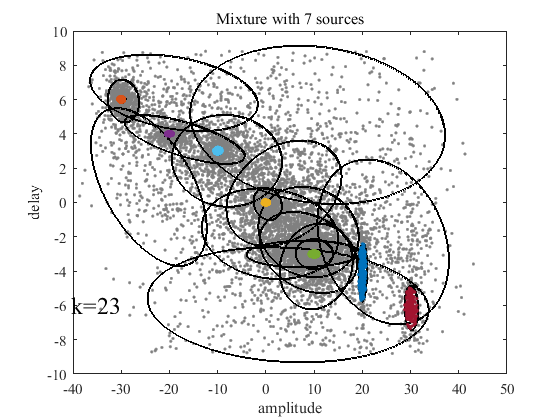

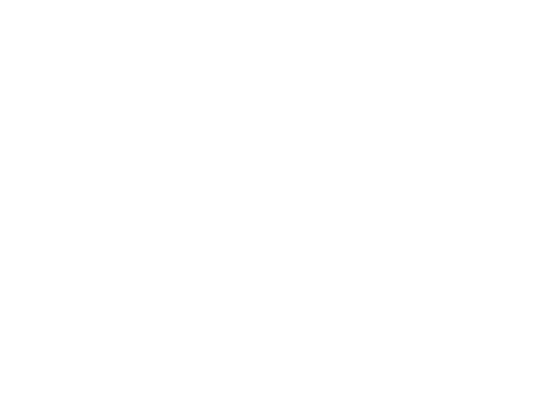

In [2]:
cd /home/jacob/panning_project/test_programs/;
load panning_data2.mat;
X = panning_data;
fs=44100;
figure;
[~,~,~,~,~,~,~,~,mu,~,X2]  = ...
smc_GMM_MMDL_normdetC(X.*[1/45 1/(150e-6*fs)], fs);
xlabel('amplitude'); ylabel('delay'); 
title('Mixture with 7 sources');

mu